In [1]:
cd ../..

C:\Users\dthiex\Documents\Fork\dton-wildfires-cleaner


#### General idea (note fully tested yet)

There are several gases that can be used to display air pollution (CO, HCHO, NO2, O3, SO2, CH4, Aerosol Index). 

1. Find the gas that shows the pollution in the event area the best:
- search for max. (mean fis value for bbox) in the 5 days before the event (when supposedly the pollution is happening) and compared to mean of the 30 days period before event
- gas with the biggest per centage difference between 5_day_max and 30_day mean is the gas that will be used to display the event. If the increase is below a certain threshold we say the increase is not big enough and we don't select a gas/event

2. Find the best before/during date
- during date = the date in the 5 days before the event with the max value (for gas determined in step 1)
- before date = date with min mean value for the gas selected in step 1 in the 30 days before the event

3. Use the during event date and the gas determinde in step 1 to ppoint the bbox
  

In [2]:
from sentinelhub import SHConfig, FisRequest, DataCollection, CustomUrlParam
from sentinelhub.time_utils import iso_to_datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from processing.pinpoint_location import get_bbox
from processing.bbox_utils import create_bbox
from datetime import datetime, timedelta, date
from utils import get_env_var

In [3]:
config = SHConfig()
config.instance_id = get_env_var("INSTANCE_ID_AIR_POLLUTION")

In [4]:
bbox_dimension= 500000 #in m
fis_duration = 30 #check 30 days before event
resolution = 50000 #before 2019 S5 has a 7km resolution, to keep request smaller set to 50 km here
fis_maxcc = 100 

# Still missing
For testing approach with several events the input needs to be connected to the database

In [5]:
lat = 39.90
long = 116.40
event_date = "2021-03-16" 

In [6]:
evalscript_fis_AER = """
//VERSION=3
if (!isFinite(AER_AI_354_388)) {
  return [NaN];
}
return[AER_AI_354_388];
"""

In [9]:
# Define FIS input parameter
data_collection = DataCollection.SENTINEL5P #Sentinel-5
layer = "AER_AI_354_388"
bbox = create_bbox(lat, long, bbox_dimension)
from_time = iso_to_datetime(event_date) - timedelta(days=fis_duration) 
to_time = iso_to_datetime(event_date) 
evalscript = evalscript_fis_AER
fis_resolution = f"{resolution}m"

In [10]:
config.download_timeout_seconds = 600
fis_request = FisRequest(
    data_collection=data_collection,
    layer=layer,
    geometry_list=[bbox],
    time=(from_time, to_time),
    resolution=fis_resolution,
    custom_url_params={CustomUrlParam.EVALSCRIPT: evalscript},
    maxcc = fis_maxcc,
    bins=1,
    config=config,
)
fis_data = fis_request.get_data()

In [11]:
data = fis_data[0]['C0']
dates = [d['date'] for d in data]
values = [d['basicStats']['mean'] for d in data]

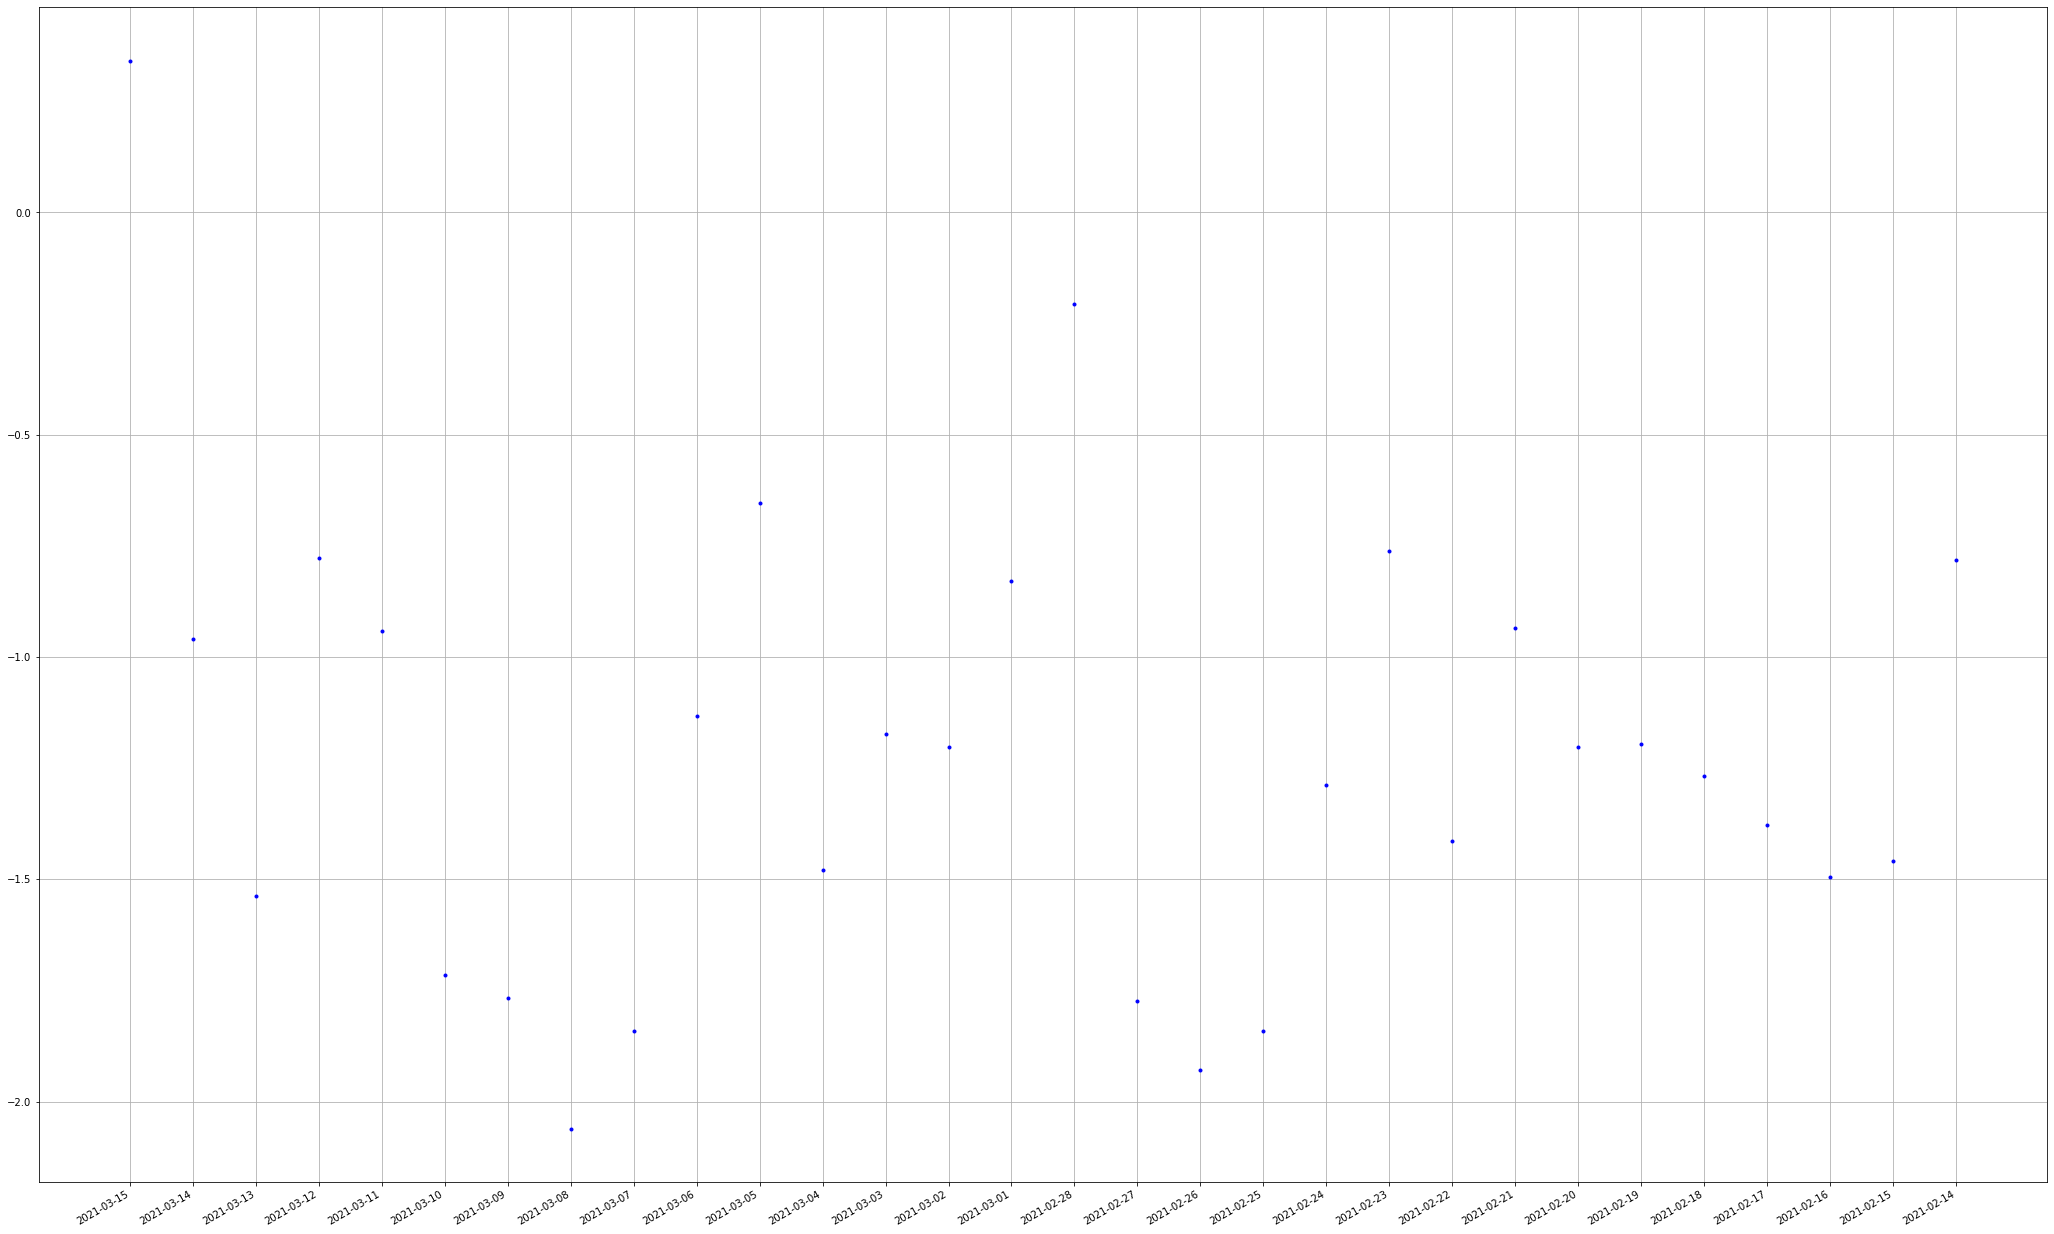

In [12]:
# PLOT OF Aerosol VALUES (not part of the processing)
plt.rcParams["figure.figsize"] = [36, 24]

fig, ax = plt.subplots()
ax.xaxis_date()
fig.autofmt_xdate()
ax.grid()
ax.plot(dates, values, 'b.')

# Still missing
The increase should be calculated for all gases and the one with the highest increase checked. If increase is >threshold continue with finding dates and pinpointing bbox. If not we couldn't find air pollution event.

In [13]:
# compare max to 30-days mean and calcualte increas in per centage
thirty_days_mean = np.nanmean(values)
index_max_5_days = np.argmax(values[:5])
increase = (values[index_max_5_days] - thirty_days_mean)/abs(thirty_days_mean)*100
print(increase)

127.98283164538277


In [14]:
# Find date with max polution
index_max_5_days = np.argmax(values[:5])
during_date = dates[index_max_5_days]
print(during_date)

2021-03-15


In [15]:
# Find date with min polution
index_min = np.argmin(values)
before_date = dates[index_min]
print(before_date)

2021-03-08


# Still missing: ppoint bbox
Centre of the bbox should be the highest value for the gas with the highest increase. Probably it would make sense to request the data here with a bit lower resolution to avoid getting a single high pixel.